In [1]:
"""Generating the HAM model from input MHD simulation

Marius Ramsøy 22/9/22"""


##########################################
#Files for download may be found here:
#https://cloud.aquila-consortium.org/s/jsNxieJyxWPPLnF?path=%2FHAM
#This uses the TNG-100 simulation as a refenence and projects it
#onto the Sibelius simulation

##########################################


#example use using TNG as reference sim and Sibelius as output

##################################################

directory="./"
#update this to reflect position of input halo catalogs, density fields and magnetic fields
N_cell=512
#effective resolution of box
Mass_threshold=1e12
#the minimum mass to consider for computing profiles and placing them back in simulation
#the default value here is quite high, allowing the process to be quite quick, but to get better results
#you should use values as low as 1e10.  This does make the process considerably slower however.
#note that S/N will be enhanced for high mass thresholds as large halos tend to congregate deep in filaments,
#enhancing the relative RM wrt the background artificially
N_shell=126
#how many cells to compute out to
f_thresh=100
#how far above Bavg the field is before the field is declared not to be part of the bubble
Bavg=1e-14
#the mean strength of the primordial field.  Default here is that of TNG. 

reset=True
#if true, then recomputes the profiles

##################################################




import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import numpy as np
from matplotlib import colors
import healpy as hp
import struct
from astropy_healpix import HEALPix 
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo


import progressbar
import progress

import time
import random
import h5py as h5
import copy
import os
import sys


import healpy as hp
import struct
from astropy_healpix import HEALPix 
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.cosmology
import progressbar
import progress

import time
import random
import h5py as h5
import copy
import numpy as np
import os
from FyeldGenerator import generate_field



from scipy.ndimage import map_coordinates
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

start=time.time()



def smooth(y,N=None):
    if(N==None):
        N=1
    print(N)
    yt=y.copy()
    if(len(y.shape)==1):
        for _ in range(N):

            #pcen

            ytemp=np.zeros((yt.size)+1,dtype=yt.dtype)
            ytemp[0]=y[0]
            ytemp[-1]=y[-1]
            ytemp[1:-1]=(yt[0:-1]+yt[1:None])/2

            #zcen
            yt=(ytemp[0:-1]+ytemp[1:None])/2
            
        #zcen
        if(N==0): return y.copy()
        return yt
    elif(len(y.shape)==3):
        for _ in range(N):

            #pcen

            ytemp=np.zeros(((yt.shape)[0]+1,(yt.shape)[1],(yt.shape)[2]),dtype=yt.dtype)
            ytemp[0,:,:]=y[0,:,:]
            ytemp[-1,:,:]=y[-1,:,:]
            ytemp[1:-1,:,:]=(yt[0:-1,:,:]+yt[1:None,:,:])/2
            print('W I P')
            ytemp[:,0,:]=y[:,0,:]
            ytemp[:,:,-1]=y[:,:,-1]
            ytemp[:,-1,:]=y[:,-1,:]
            
            #zcen
            yt=(ytemp[0:-1,0:-1,0:-1]+ytemp[1:None,1:None,1:None])/2
        #zcen
        if(N==0): return y.copy()
        return yt

def rotateArray(arr,angle,axis=0,fill_value=0,method='linear'):
    N=arr.shape[0]
    trp=[axis]+list({0,1,2}-{axis,axis})
              
    rt=np.transpose(arr.copy(),trp)
    x=np.repeat(np.expand_dims(np.linspace(-1,1,N),axis=1),N,axis=1)
    y=x.T
    yp=x*np.sin(angle)+y*np.cos(angle)
    xp=x*np.cos(angle)-y*np.sin(angle)
    #stat(x,y,xp,yp)
    rt2=np.zeros((N,N*N))
    #stat(np.array([x.ravel(),y.ravel()]))
    #for i in range(N):
    for i in progressbar(range(N), "Computing: ", 40):    
        temp=griddata((x.ravel(),y.ravel()),rt[i,:,:].ravel(),(xp.ravel(),yp.ravel()),method=method,fill_value=fill_value)
        rt2[i,:]=temp.copy()
    
    return np.transpose(rt2.reshape((N,N,N)),np.sort(trp))

def smooth3d(field,N=1):
    return field
    for n in range(N):
        field2=field.copy()*0
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    field2+=np.roll(field,[i,j,k,0],axis=(0,1,2,3))
        

        field=field2/8
    return field



def scale_up(field,N=1):
    #not intended as opposite to interp_down
    #works on 3d field, not face field
    
    for n in range(N):
        dims=field.shape
        field2=np.zeros((dims[0]*2,dims[1]*2,dims[2]*2),dtype=field.dtype)
        for i in range(2):
            for j in range(2):
                for k in range(2):


                    field2[i::2,j::2,k::2]=field
        field=field2.copy()
    return field
    




def profile_rescale(profiles,N2,s=1):
    N1,n=profiles.shape
    
    p2=np.zeros((N2,n),dtype=float)
    r=np.linspace(1,N1,num=N1,endpoint=True)/N1/s
    rnew=np.linspace(1,N2,num=N2,endpoint=True)/N2
    
    #for i in progressbar(range(n), "Computing: ", 40):
    count=0
    print('interpolating profiles')
    for i in range(n):
        if(i%1000==0):
            print(100*i//n,"%")
        if(np.mean(profiles[:,i])==0):
            if(count>100):
                break
                #stop once 100 halos in a row hoave no profile
                #every other profile has then been wiped out by
                #larger halos
            else:
                count+=1
        else:
            count=0
           
        fr2 = interp1d(r, profiles[:,i]*r**2, kind='cubic',fill_value=(profiles[0,i]*r[0]**2,0),bounds_error=False) 
        
        r2=interp1d(r, r**2, kind='cubic',fill_value=(rnew[0]**2,rnew[-1]**2),bounds_error=False)
        p2[:,i]=abs(fr2(rnew)/r2(rnew))
        
        x=np.where(profiles[:,i]==0)[0]
        if(x.size!=0):
            x=x[0]
        else:
            x=0
        x=np.where(rnew>r[x])[0]
        if(x.size):
            p2[x[0]:None,i]=0
    return p2






def norm(v):
    l=len(v.shape)
    
    L=np.sqrt(np.sum(v**2,axis=l-1))
    #if(L==0):
    #    L=1
    return L



def stat(*args):
    i=0
    for arr in args:
        i=i+1
        print('array: '+str(i)+' shape:',arr.shape,"min: ",np.min(arr),"max: ",np.max(arr),"avg: ",np.mean(arr),"std: ",np.std(arr))
    

def progressbar(it, prefix="", size=60, file=sys.stdout):
    #usage:
    
    # for i in progressbar(range(N), "Computing: ", 40):
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j, count))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()
    
def Pkgen(n1,cut,n2,exp_cut,kfloor):
    
    def Pk(k):
        arr=k.copy()
        
        if(exp_cut==False):
            ppp=np.where(k<cut,np.power(k+kfloor,n1),np.power(k+kfloor,n2)*(cut+kfloor)**(-n2+n1))
        else:
            ppp=np.where(k<cut,np.power(k+kfloor,n1),np.exp(-(k+kfloor)/n2)/(cut+kfloor)**(-n1)/np.exp(-(cut+kfloor)/n2))
        
        
        return ppp

    return Pk

def distrib(shape):
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b


def GRF(shape,n1,cut,n2,exp_cut,kfloor):
    #cut should be at N*0.5/shape[0] roughly
    #if using exponential cut-off, then same order should be used to 
    #pick the scale
    #example 
    
    #shape=(N,N)
    #field=GRF(shape,4,50*0.5/N,0.1*0.5/N,True,0.5/N)
    
    

    return generate_field(distrib,Pkgen(n1,cut,n2,exp_cut,kfloor), shape)





def fg_load(fname,subtract):
    #'faraday2020.hdf5'
    f=h5.File(fname,'r')

    asm=np.array(f[list(f.keys())[0]],float)
    if(subtract==1):
        asd=np.array(f[list(f.keys())[1]],float)

        asd=np.random.normal(0,asd)
        return asd
    return asm

def hp_interp(hp_in,nside_in,nside_out,frame_in='icrs',frame_out='icrs',long_rotate=0):
    hpp2=HEALPix(nside=nside_out,frame=frame_out)                                                                                                                                                                                 
    lon2, lat2 = hpp2.healpix_to_lonlat(range(hpp2.npix))
    
    coords = SkyCoord(lon2+long_rotate*u.deg, lat2,frame=frame_out)

    hpp=HEALPix(nside=nside_in,frame=frame_in)
    v=np.array(hpp.interpolate_bilinear_skycoord(coords, hp_in),float)
    return v




In [2]:
def p_field_gen(density,amplitude=1e-14,frac=0.1,scale=16):
    """Produces a primordial field with a broken powerlaw index 4 
    rising and -5/3 falling with a peak at 16 cells (default)
    Typically this component will be quite weak so can choose to
    ignore it.
    """
    print('-------------------')
    print("Running p_field_gen")
    print('-------------------')
    print('This function may be slow to execute depending on the size of the input cube')
    shape=density.shape[0]
   
   
   
    n1=4-2
    n2=-5/3*2-2
    exp_cut=False

    cut=scale
    r1=GRF((shape,shape,shape),n1*2,30*0.5/shape,n2,exp_cut,0.5/shape/10)
    N=np.std(r1)
    r1/=N

    r2=GRF((shape,shape,shape),n1*2,30*0.5/shape,n2,exp_cut,0.5/shape/10)/N
    r3=GRF((shape,shape,shape),n1*2,30*0.5/shape,n2,exp_cut,0.5/shape/10)/N
    Bf=np.zeros((shape,shape,shape,3))
    
    Bog=((density/np.mean(density))**(2./3))
    Bf[:,:,:,0]=(Bog*frac*r1)
    Bf[:,:,:,1]=(Bog*frac*r2)
    Bf[:,:,:,2]=(Bog*(1+frac*r3))
    Bf=Bf/np.mean(np.sqrt(np.sum(Bf**2,axis=3)))*amplitude
    
    return Bf#Bf[:,:,:,0].ravel(),Bf[:,:,:,1].ravel(),Bf[:,:,:,2].ravel()

def index_shells(N_shell,N_cell):
    indexes=[]
    s=N_cell
    
    rt=np.linspace(-s/2,s/2-1,s)
    rz=np.tile(rt,(s,s,1))
    ry=np.transpose(rz,(0,2,1))
    rx=np.transpose(rz,(2,1,0))
    r=np.sqrt(rx*rx+ry*ry+rz*rz)
    rz=ry=rx=rt=[]
    r=np.array(r,dtype=int)
   
    r=np.roll(r,-int(N_cell/2),axis=(0,1,2))
    print('indexing\n...\nThis may take some time the first time')
    #for i in range(N_shell):
    for i in progressbar(range(N_shell), "Computing: ", 40):
            #print(int(1000*i/N_shell)/10,"%")
            #gather the indices
            U=np.array(np.where(r==i))
            U=np.array(U)
            indexes.append(U)
            #indexes.append(np.unravel_index((np.where(r==i)[0]),(N_cell,N_cell,N_cell)))
    print(100,"%")
    return indexes


def load_index(N_shell,N_cell):
    """Loads the relative positions of the cells on each of the N_SHELL shells of cells.
    N_CELL is the number side length of the box in cells.  When first run it will save the
    indices so it doesn't have to rerun the whole thing later"""
    if((os.path.isfile('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp.h5'))):
        hf=h5.File('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp.h5','r')
        #indexes=[hf[key][()] for key in list(hf.keys())]
        #keys arranged alphabetically
        #->
        indexes=[hf['L_'+str(i)][()] for i in range(N_shell)]
        hf.close()
        return indexes
    else:
        #numpy doesn't like lists of lists
        indexes=index_shells(N_shell,N_cell)
        hf = h5.File('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp.h5', 'w')
        for i in range(N_shell):
            hf.create_dataset("L_"+str(i), data=indexes[i])
        hf.close()
        return indexes
       # np.savez('indexes_'+str(N_shell)+'_'+str(N_cell)+'.tmp',np.array(indexes,dtype=object))


def get_B_profiles(pos,M,B,dens,indexes,N_shell,f_thresh=100,Bavg=1e-14,Mthresh=1e9,dims=64):
    """extracts magnetic amplification profiles from the magnetic field (Magnetic field/rho^(2/3) 
    POS are positions of halo as an np array,shape (N,3)
    M are the halo masses in solar units
    B is a 3D array shape(N_cell,N_cell,N_cell) contiaining the magnitude of the magnetic field
    in Gauss
    DENS is the density (any units)
    N_shell is how far out to evaluate the magnetic shells out to using INDEXES which stores the shell indices.  Having a large value degrades computational
    performance and doesn't add much to the magnetic field, a reasonable value is 64.
    F_THRESH is the threshold at which the magnetic bubble ceases to belong to the current halo
    this is some multiple of BAVG, the average magnetic field of the primordial field. 
    MTHRESH is the mass at which to stop considering halos
    DIMS is the grid for determining the local halo environment
    
    
    OUTPUTS:  (A(r) (modified Gauss units..?,Mass (M_{sol}),Environment Mass (M_sol)))
    """
    
    N_cell=B.shape[0]
    B=B.ravel()
    dens=dens.ravel()/np.mean(dens)
    env, edges = np.histogramdd(pos,bins=(dims,dims,dims),range=((0,N_cell-1),(0,N_cell-1),(0,N_cell-1)),weights=M)
    env=env.ravel()
    i=0
    #sort array according to mass
    arg=np.argsort(-M)
    pos=pos[arg,:]
    M=M[arg]
    x=np.where(M>Mthresh)[0]
    print(x.size)
   
    dens=dens/np.mean(dens)
    dens+=0.01
    
    if(x.size):
        Ns=x.size
        #data=np.array((N_shell,int(Ns[i])),dtype=object)
        data=[]
        envdata=[]
        #ratdata=[]
        data=np.zeros((N_shell,Ns),dtype=float)
        data_s=np.zeros((N_shell,Ns),dtype=float)
        
        
        for j in range(Ns):
            
            if(j%int(max(0.01*Ns,1))==0):
                print(int(j*100/Ns),int(100*np.log10(M[x[j]]))/100,j)
                
            envdata.append(env[np.ravel_multi_index(np.array(pos[x[j],:]/N_cell*dims,dtype=int),(dims,dims,dims),mode='wrap')])
            #ratdata.append(env[np.ravel_multi_index(np.array(pos[x[j],:]/N_cell*dims,dtype=int),(dims,dims,dims),mode='wrap')]/M[x[j]])
            dywtc=False
            Btemp3=0
            for k in range(N_shell):
                
                indices=np.ravel_multi_index((np.expand_dims(pos[x[j],:],axis=1)-indexes[k])%N_cell,(N_cell,N_cell,N_cell),mode='wrap')
                Btemp=B[indices]
                
                z=np.where((Btemp!=0)*(dens[indices]!=0))[0]
                Btemp2=0
                if(z.size):
                    
                    Btemp2=np.median(Btemp)
                    data[k,j]=np.median(Btemp[z]/dens[indices[z]]**(2./3))
                    
                    
                   
                if(Btemp2<f_thresh*Bavg+dywtc):
                    #bubble is finished
                    dywtc=True
                    break
                else:
                    B[indices]=0

                    #delete this part of the bubble

           
        


            
            
    
    return data,M[x],envdata

    
def emulateBubbles(pos,M,dens,Bavg,indexes,A=None,hal_envirs=None,Masses=None,dims=64,rescale_factor=1,Mthresh=3e10):
    """function inserts magnetic bubbles ubject to the halos, the magnetic enhancement profiles, A, and the density field, DENS
     RESCALE_FACTOR is the ratio of the length scale of the current DM simulation to the reference
     simulation.  HAL_ENVIRS is the halo environment and MASSES are the masses, both from the reference simulation
     All other variables are shared with the function index_shells or get_B_profiles.
     
     outputs cube with shape (N_cell,N_cell,N_cell,3)
    """
    
    arg=np.argsort(-M)
    pos=pos[arg,:]
    M=M[arg]
    #reorder halos
    
    r23=((dens/np.mean(dens))**(2./3)).ravel()
    
    #enhancement field
    N_cell=dens.shape[0]
    B=[np.zeros((N_cell**3),dtype=float),np.zeros((N_cell**3),dtype=float),np.zeros((N_cell**3),dtype=float)]
    N_shell=len(indexes)
    
    count=0
   
    env, edges = np.histogramdd(pos,bins=(dims,dims,dims),range=((0,N_cell-1),(0,N_cell-1),(0,N_cell-1)),weights=M)
    env=env.ravel()*rescale_factor**3
    #print('minimum environment:',np.min(env))
    x=np.where(env!=0)[0]
    minenv=np.min(env[x])
    x=np.where(env==0)[0]
    if(x.size):
        env[x]=minenv

    if(hal_envirs==None):   
        f=np.load('A_profiles.npz',allow_pickle=True)
        A=f['arr_0']
        Masses=f['arr_1']
        hal_envirs=np.array(f['arr_2'])+1e-8
    hal_envirs+=1e-8
   
    
    profiles=A#*C
    #note that the corrective factor, C, is calculated after
    #and is then applied before adding any primordial component
    if(rescale_factor!=1):
        profile=profile_rescale(profiles,N_shell,rescale_factor)
    #cubic interpolation of profiles
    else:
        profile=profiles
    
    i=0
    print('calculating field...')
  
   
   
    
    x=np.where(M>Mthresh)[0]
    if(x.size):
        Ns=x.size

        #moves profiles into descending mass order
        data=np.zeros((N_shell,int(Ns)),dtype=float)
        for j in range(Ns):
            
            if(j%int(max(0.02*Ns,2))==0):
                print(str(int(j*100/Ns))+ "%")
            
            jindex=np.where(abs(Masses-M[x[j]])==np.min(abs(Masses-M[x[j]])))[0][0]
               
            
            sig=0.01
            envir=env[np.ravel_multi_index(np.array(pos[x[j],:]/N_cell*dims,dtype=int),(dims,dims,dims),mode='wrap')]
            #get local environment
            Dm=np.random.normal(np.log10(M[x[j]]),sig)
            s=((np.log10(Masses)-Dm))**2+np.log10(hal_envirs/envir)**2
            #stochastic variable
            #minimise the varible s to get the closest mass halo while also a similar environment
            #variables are on the same scale so no need to normalise.  Both are clearly very important
            #to be matched so we don't attempt to adjust this
            jindex=np.where(s==np.min(s))[0][0]
            #
            
            Bi=profiles[:,jindex]
            #magnetic amplification profiles
            dywtc=False

            for k in range(N_shell):

                
               
                indices=np.ravel_multi_index((np.expand_dims(pos[x[j],:],axis=1)-indexes[k])%N_cell,(N_cell,N_cell,N_cell),mode='wrap')
                
                if((Bi[k]*np.median(r23[indices])>Bavg)):    

                    dirs=1000*(np.random.random((indices.size,3))-0.5)
                    #choose random direction for field in shell
                    NN=np.sqrt(np.sum(dirs**2,axis=1))
                    
                    for ii in range(3):
                        dirs[:,ii]/=NN
                        #normalise
                    for ii in range(3):
                        B[ii][indices]= B[ii][indices]+Bi[k]*dirs[:,ii]*r23[indices]
                        #Bi contains the median over-magnetisation, so multiplying by local rho^2/3
                        #should give the proper magnetic field
                else:
                    #bubble no longer contributing
                    break 
            """
            if(j%100==0):
                Br=np.zeros((N_cell,N_cell,N_cell,3),dtype=float)
                for i in range(3):
                        Br[:,:,:,i]=B[i].reshape((N_cell,N_cell,N_cell))
                plt.imshow(np.log(np.sum(np.sqrt(np.sum(Br**2,axis=3)),axis=2)))
                plt.show()
                stat(Br)
                print(np.log10(M[x[j]]))
                print(A[:,jindex])
            """
    Br=np.zeros((N_cell,N_cell,N_cell,3),dtype=float)
    for i in range(3):
                        Br[:,:,:,i]=B[i].reshape((N_cell,N_cell,N_cell))
    return Br




def lin_int(RMs,zs,zmax,box_size):
    """Linear Integration of the RM along the line of sight.  Computes median, 84th and 16th percentiles
    (1 sigma) as well as z at each position.  Computation projects sightlines through the box, but repeats the box
    once the edge is reached.  To prevent the sightline passing through the same region of space repeatedly
    the box is translated by a random amount each time, and is given a random sign.  If you have multiple snapshots
    you can put in the RMcube along with the redshift.  A RMcube is used until the next redshift in the list is reached.
    B should be comoving units and lin_int will correct the units in the output.
    
    
    Inputs:
    
    RMS are a list of rotation measure cubes, with correct units radm^-2, ZS are the redshifts of the cubes, zmax is 
    the redshift to integrate to and BOX_SIZE is the xize of the box in Mpc"""
    i=-1
    j=-1
    zo=[]
    zs.append(zmax)
    z_int=0
    dD=box_size
    D=0
    RRR=[]
    RRRu=[]
    RRRd=[]
    s=RMs[0].shape[0]
    temp=0
    for RM in RMs:
        i=i+1
        
        z=zs[i]
        
        #collapse RMs
        
        RMtemp=np.zeros((s,s,3),dtype=float)
        for k in range(3):
            RMtemp[:,:,k]=np.sum(RM[:,:,:,k],axis=k)
        
        
        
        
        while(z_int<zs[i+1]):
            j=j+1
            print("z="+str(np.round(z_int,decimals=1)))
            
            u_s_e=random.choice([0,1,2])
            
            ftemp=RMtemp[:,:,u_s_e]
            #
            ra=int(s*np.random.rand())
            rb=int(s*np.random.rand())
            rc=int(s*np.random.rand())
            ftemp=np.roll(ftemp,ra,axis=0)
            ftemp=np.roll(ftemp,rb,axis=1)
            temp=temp+((ftemp)*random.choice([-1,1])/((1+z_int)/(1+z))**(-1))
            
            #last part interploates to the correct intermediate redshift
           
            temptemp=np.sort(abs(temp).ravel())
            
            RRR.append(temptemp[int(0.5*s*s)])
            
            RRRu.append(temptemp[int(0.84*s*s)])
            RRRd.append(temptemp[int(0.16*s*s)])
            zo.append(z_int)
            
            D=D+dD/(1+z_int)
            z_int=astropy.cosmology.z_at_value(cosmo.comoving_distance,D*u.Mpc)
       
             
    return (np.array(RRR,dtype=float),np.array(RRRu,dtype=float),np.array(RRRd,dtype=float)),np.array(zo,dtype=float)


def Compute_Norm(B,dens,box_size,znorm,Bog):
    """Computes the normalisation of the HAM model, subject to the condition that the model produces
    the same RM at z=znorm.  Only distance need to be correct here.  BOG is the original magnetic field
    fed into get_B_profiles."""
    
    #RMs=[B[:,:,:,i]*dens for i in range(3)]
    #RMsOG=[Bog[:,:,:,i]*dens for i in range(3)]
    RMs=[B*np.expand_dims(dens,axis=3)]
    RMsOG=[Bog*np.expand_dims(dens,axis=3)]
    RM_int=lin_int(RMs,[0],znorm,box_size)
    RM_int_OG=lin_int(RMsOG,[0],znorm,box_size)
    
    plt.plot(RM_int[-1],RM_int_OG[0][0]/RM_int[0][0])
    
    return RM_int_OG[0][0][-1]/RM_int[0][0][-1]
    #typical values are around 6

def MW_plt(arr,floor,Log,title,cmin,cmax,cmap,Type,axes=None,cbar_title=""):
    #mollweide plots
    f=plt.figure()
    
    if(Log*(Type=="RM")):
        
        x=np.where(arr>10**cmax)[0]
        if(x.size>0):
            arr[x]=10**cmax
        x=np.where(arr<-10**cmin)[0]
        if(x.size>0):
            arr[x]=-10**cmin
        norm=colors.SymLogNorm(linthresh=10**floor,linscale=10**floor,vmax=10**cmax,vmin=-10**cmax)
        hp.mollview(arr, fig=1, coord='CG',title=title,notext=True,bgcolor='white',badcolor='white',cmap=cmap,norm=norm,max=10**cmax,min=-10**cmin,cbar=False)
    
    elif(Log):
        x=np.where(arr>10**cmax)[0]
        if(x.size>0):
            arr[x]=10**cmax
        x=np.where(arr<10**cmin)[0]
        if(x.size>0):
            arr[x]=10**cmin
        
        
        #hp.mollview(np.log10(abs(arr)+floor), fig=1, coord='G',title=title,notext=True,min=cmin,max=cmax,cmap=cmap)
        norm=colors.LogNorm(vmax=10**cmax,vmin=10**cmin)
        hp.mollview(arr, fig=1, coord='CG',title=title,notext=True,cmap=cmap,badcolor='white',bgcolor='white',norm=norm,max=10**cmax,min=10**cmin,cbar=False)

    else:
        x=np.where(arr>cmax)[0]
        if(x.size>0):
            arr[x]=cmax
        x=np.where(arr<cmin)[0]
        if(x.size>0):
            arr[x]=cmin
        x=np.where(arr!=0)[0]
        floor=np.min((arr[x])+floor)
        norm=colors.Norm(vmax=cmax,vmin=cmin)
        hp.mollview(arr+floor, fig=1, coord='CG',title=title,badcolor='white',notext=True,min=cmin,max=cmax,cmap=cmap,bgcolor='white',cbar=False)
        norm=None
    if((Type=="delection")+(Type=="RM")):
        grat_kwargs=dict(color='w')
        hp.graticule(**grat_kwargs)
    else:
        hp.graticule()
    
    plt.colorbar(plt.cm.ScalarMappable(norm=norm,cmap=cmap),shrink=0.8,ax=axes,label=cbar_title,orientation='horizontal')
   
    return f




def MW_name_plt(Type,Sim):
    #mollweide plot names of signicant clusters
   
    ra=np.array([136.93735874, 150.38174584, 168.57327953, 243.1381037 ,
        170.61562534, 269.63026749, 149.25536886,  58.08616113,
         42.87520738,  31.58781883,  39.90336886, 302.41203918,
        317.45967005, 325.33074435, 352.5911349 , 269.57866176,
        279.6763    , 124.7055    ,  87.7031    ])
    dec=np.array([-53.259941  , -13.38152317,  22.80672409,  25.07020132,
         57.88772667,  26.50587452,  54.17871741,  87.95760795,
         56.56097245,  44.52158698, -39.9750057 ,  21.56331536,
         30.93993674,  -7.25575427, -42.1546694 ,  26.49532999,
         74.4596    , -32.1947    , -48.3286    ])

    names=np.array(['V ZW 8 Group', 'Perseus Cluster', 'SMAC ACO 0569S',
        'Hydra A Cluster', 'III ZW 10 Group', 'Hydra I Cluster',
        'Ursa Major II Cluster', 'Coma Cluster', 'CrB Cluster',
        'Hercules Cluster', 'RXC J2127-1209', 'Centaurus Group',
        'IC 4329 Group', 'Norma Cluster', 'NGC 7014 Group',
        'Hydra I Cluster', 'Virgo', 'Pisces', 'Pegasus'], dtype='<U21')
  
    #hp.projscatter(ra,dec,lonlat=True)
    if(Type=='d'):
        col="black"
    elif(Type=="B"):
        col='aqua'
    elif(Type=='deflection'):
        col='forestgreen'
        if(Sim=='P'):
            col='black'

    elif(Type=='deflection'):
        col='forestgreen'
    else:
        #col='royalblue'
        col='black'
    print(ra.size,"Clusters found")
    for i in range(ra.size):
        if(names[i][0:3]!='ACO'):
            #name transformations
            t=names[i]
            ft=t.find("Cluster")
            if(ft!=-1):
                t=t[0:ft-1]
            
            ft=t.find("Group")
            if(ft!=-1):
            #    continue
                t=t[0:ft-1]
 
            scatter_kwargs = dict(marker="o", facecolors='none', edgecolors='b', linewidth=1.)
            hp.projscatter(ra[i],dec[i],lonlat=True,coord="G",**scatter_kwargs)
            
            hp.projtext(ra[i],dec[i],t,lonlat=True,coord="G",size=9,color=col)
           
    ras=[-179,0,179]
    decs=2
    n=['-180','0','180']
    for i in range(3):
        hp.projtext(ras[i],decs,n[i],lonlat=True,coord="G",size=9,color='black')

def fg_load(fname,subtract):
    #load galactic foreground, subtract==1 uses the standard deviation to approximate the subtracted RM sky
    #'faraday2020.hdf5'
    f=h5.File(fname,'r')

    asm=np.array(f[list(f.keys())[0]],float)
    if(subtract==1):
        asd=np.array(f[list(f.keys())[1]],float)

        asd=np.random.normal(0,asd)
        return asd
    return asm


def med2d(arr1,arr2,bins=30,ranges=None,color=None,r=1):
    #get median from distribution
    val=np.zeros((bins-1))
    val2=np.zeros((bins-1))
    N=np.zeros((bins-1))
    xbin=np.linspace(ranges[0],ranges[1],bins)
    for i in range(bins-1):
        x=np.where((arr1.ravel()>xbin[i])*(arr1.ravel()<xbin[i+1]))[0]
        if(x.size>4):
            val[i]=np.median(arr2.ravel()[x])
            val2[i]=np.sort(arr2.ravel()[x])[int(0.84*x.size)]*3
            N[i]=x.size
    N/=r
    x=np.where(val!=0)[0]
    
    return xbin,val,N

def radial(s):
    #gets normalised unit vectors pointing away from centre of SxSxS box
    r=np.zeros((s,s,s,3))
    
    t=np.linspace(-s/2,s/2,s)
    r[:,:,:,0]=np.expand_dims(t,(1,2))
    r[:,:,:,1]=np.expand_dims(t,(0,2))
    r[:,:,:,2]=np.expand_dims(t,(0,1))
    r/=np.expand_dims(norm(r),3)
    return r

def MW_plt2(arr,floor,Log,title,cmin,cmax,cmap,Type,axes=None,cbar_title=""):
    #plots a Mollweide plot, similar but slightly different from M_plt2
    f=plt.figure()
    
    if(Log*(Type=="RM")):
        
        x=np.where(arr>10**cmax)[0]
        if(x.size>0):
            arr[x]=10**cmax
        x=np.where(arr<-10**cmin)[0]
        if(x.size>0):
            arr[x]=-10**cmin
        norm=colors.SymLogNorm(linthresh=10**floor,linscale=10**floor,vmax=10**cmax,vmin=-10**cmax)
        hp.mollview(arr, fig=1, coord='CG',title=title,notext=True,bgcolor='white',badcolor='white',cmap=cmap,norm=norm,max=10**cmax,min=-10**cmin,cbar=False)
    
    elif(Log):
        x=np.where(arr>10**cmax)[0]
        if(x.size>0):
            arr[x]=10**cmax
        x=np.where(arr<10**cmin)[0]
        if(x.size>0):
            arr[x]=10**cmin
        
        
        #hp.mollview(np.log10(abs(arr)+floor), fig=1, coord='G',title=title,notext=True,min=cmin,max=cmax,cmap=cmap)
        norm=colors.LogNorm(vmax=10**cmax,vmin=10**cmin)
        hp.mollview(arr, fig=1, coord='CG',title=title,notext=True,cmap=cmap,badcolor='white',bgcolor='white',norm=norm,max=10**cmax,min=10**cmin,cbar=False)

    else:
        x=np.where(arr>cmax)[0]
        if(x.size>0):
            arr[x]=cmax
        x=np.where(arr<cmin)[0]
        if(x.size>0):
            arr[x]=cmin
        x=np.where(arr!=0)[0]
        floor=np.min((arr[x])+floor)
        norm=colors.Norm(vmax=cmax,vmin=cmin)
        hp.mollview(arr+floor, fig=1, coord='CG',title=title,badcolor='white',notext=True,min=cmin,max=cmax,cmap=cmap,bgcolor='white',cbar=False)
        norm=None
    
    plt.colorbar(plt.cm.ScalarMappable(norm=norm,cmap=cmap),shrink=0.8,ax=axes,label=cbar_title,orientation='horizontal')
   
    return f


def fil_cat(lons,lats,Np=100):
    #interpolates a straight line between two points across the sky with Np points
    """gets the Np points between the list of pairs of points in galactic lat and lon
    each should be a np array of shape (N,2)"""
    N=lons.shape[0]
        
    Ls=np.zeros((Np,3,N))
    for i in range(N):
        
        
        p1=SkyCoord(lons[i,0]*u.deg,u.deg*lats[i,0],distance=1,frame='galactic').icrs.cartesian
        p2=SkyCoord(lons[i,1]*u.deg,u.deg*lats[i,1],distance=1,frame='galactic').icrs.cartesian
        
        
        p1=np.array([p1.x.value,p1.y.value,p1.z.value])
        p2=np.array([p2.x.value,p2.y.value,p2.z.value])
        
        Ls[:,:,i]=(np.expand_dims(p1,0)+np.expand_dims(np.linspace(0,1,Np),1)*(np.expand_dims(p2-p1,0)))
    cs=[]
    for i in range(N):
        sctemp=SkyCoord(u=Ls[:,0,i],v=Ls[:,1,i],w=Ls[:,2,i],frame='galactic',representation_type='cartesian')
        cs.append(sctemp)
    return cs


def plt_med2d(arr1,arr2,bins=30,ranges=None,color=None,r=1,ls=None,alpha=None):
    #get the median of a distribution and plots it
    val=np.zeros((bins-1))
    val2=np.zeros((bins-1))
    N=np.zeros((bins-1))
    xbin=np.linspace(ranges[0],ranges[1],bins)
    for i in range(bins-1):
        x=np.where((arr1.ravel()>xbin[i])*(arr1.ravel()<xbin[i+1]))[0]
        if(x.size>4):
            val[i]=np.median(arr2.ravel()[x])
            val2[i]=np.sort(arr2.ravel()[x])[int(0.84*x.size)]*3
            N[i]=x.size
    N/=r
    x=np.where(val!=0)[0]
    plt.plot(10**xbin[x],10**val[x],color=color,linestyle=ls,alpha=alpha)
    #plt.plot(xbin[x],val2[x],linestyle='dashed')
    #plt.plot(xbin[x],val[x]+abs(val[x]-val2[x])/np.sqrt(N[x]),color=color,linestyle='dotted')
    #plt.plot(xbin[x],val[x]-abs(val[x]-val2[x])/np.sqrt(N[x]),color=color,linestyle='dotted')
    return xbin,val,N

def get_seps(fils,nside,Np=100):
    #using the output of fil_cat, computes the distance across the sky from
    #filaments to each point.   Outputs this for each filament
    hpp=HEALPix(nside=nside,frame='icrs')                                                                                                                                                                                 

    lon, lat = hpp.healpix_to_lonlat(range(hpp.npix))                                                                                                                                                     

    coords = SkyCoord(lon, lat,frame='galactic').galactic
    seplist=[]
    fullsep=lon.value*0+100000
    for j,fil in enumerate(fils):
        print(j)
        seplist.append(lon.value*0+100000)
        for i in range(Np):

            sep=coords.separation(fil[i]).value.copy()

            seplist[j]=np.where(sep<seplist[j],sep,seplist[j])
        fullsep=np.where(fullsep<seplist[j],fullsep,seplist[j])
    return seplist,fullsep

def banned_band(angle):
    #removes the band around the equator of an icrs from healpix as indices
    hpp=HEALPix(nside=nside,frame='icrs')                                                                                                                                                                                 

    lon, lat = hpp.healpix_to_lonlat(range(hpp.npix))                                                                                                                                                     

    coords = SkyCoord(lon, lat,frame='icrs')
    coords=coords.galactic
    x=np.where(abs(coords.b)>angle*u.deg)[0]
    return x

def norm(v):
    ###Computes the norm of a vector field
    l=len(v.shape)
    
    L=np.sqrt(np.sum(v**2,axis=l-1))
    
    return L


In [6]:

#Load all files required to run model.  Can substitute in own reference MHD simulation and DMO simulation
#here


f=np.load(directory+'/TNGhal.npz',allow_pickle=True)
pos=f['arr_0']

pos=np.array(N_cell*(1.0*pos/(np.max(pos)-np.min(pos))),dtype=int)
#convert the positions from whatever units they are in into N_cell based coordinates

M=f['arr_1']

#mass units are irrelevant as long as you make sure to change the default mass thresholds, but set at 1e9 M_sol for get_B_profiles
#position is in cell units, from 0 to N_cell-1
f=np.load(directory+'TNG99.npz',allow_pickle=True)
#
dens=f['arr_0']
BOG=f['arr_2']/512**3 
#correcting units to Gauss


#loading Sibelius data

f=np.load(directory+'/Sibhal.npz',allow_pickle=True)
pos_sib=f['arr_0']
pos_sib=np.array(N_cell*(1.0*pos_sib/(np.max(pos_sib)-np.min(pos_sib))),dtype=int)

M_sib=f['arr_1']
#get halos from target simulation, again rescaled from 0 to N_cell-1
dens_sib=smooth3d(np.load(directory+'DMSib199.npz')['arr_0'])*0.1667
#get density field
#in this case Sibelius is a DM only simulation, so I have smoothed it a little to make it more similar to gas, but this is probably not necessary 
#there are however significant differences between the normalised gas and DM densities at scales important to the galactic pollution
#which are definitely modelled incorrectly.



In [7]:
indexes=load_index(N_shell,N_cell)
#may take a while when first running, but saved for future runs

#this is for producing the concentric shells of the magnetic bubbles

In [8]:
#produce the magnetic profiles.  Can set RESET=True to recompute, otherwise step will be skipped once previously computed
if((not (os.path.isfile('A_profiles.npz')))or ( reset)):
    Bn=np.sqrt(np.sum(BOG**2,axis=3))
    A,Masses,Envirs=get_B_profiles(pos,M,Bn,dens,indexes,N_shell,f_thresh=100,Bavg=1e-14,Mthresh=Mass_threshold,dims=64)
    np.savez('A_profiles.npz',A,Masses,Envirs)


2195
0 14.74 0
0 14.0 21
1 13.79 42
2 13.61 63
3 13.44 84
4 13.35 105
5 13.28 126
6 13.21 147
7 13.17 168
8 13.13 189
9 13.06 210
10 13.02 231
11 12.97 252
12 12.93 273
13 12.91 294
14 12.88 315
15 12.85 336
16 12.83 357
17 12.8 378
18 12.78 399
19 12.76 420
20 12.73 441
21 12.71 462
22 12.68 483
22 12.67 504
23 12.65 525
24 12.64 546
25 12.61 567
26 12.6 588
27 12.59 609
28 12.58 630
29 12.56 651
30 12.54 672
31 12.53 693
32 12.51 714
33 12.5 735
34 12.49 756
35 12.47 777
36 12.45 798
37 12.44 819
38 12.42 840
39 12.42 861
40 12.41 882
41 12.4 903
42 12.39 924
43 12.38 945
44 12.37 966
44 12.36 987
45 12.35 1008
46 12.34 1029
47 12.32 1050
48 12.32 1071
49 12.31 1092
50 12.3 1113
51 12.29 1134
52 12.28 1155
53 12.27 1176
54 12.26 1197
55 12.25 1218
56 12.24 1239
57 12.23 1260
58 12.23 1281
59 12.22 1302
60 12.21 1323
61 12.21 1344
62 12.2 1365
63 12.2 1386
64 12.19 1407
65 12.18 1428
66 12.18 1449
66 12.17 1470
67 12.17 1491
68 12.16 1512
69 12.15 1533
70 12.15 1554
71 12.15 1575
72 1

calculating field...
0%
1%
3%
5%
7%
9%
11%
13%
15%
17%
19%
21%
23%
25%
27%
29%
31%
33%
35%
37%
39%
41%
43%
45%
47%
48%
50%
52%
54%
56%
58%
60%
62%
64%
66%
68%
70%
72%
74%
76%
78%
80%
82%
84%
86%
88%
90%
92%
94%
95%
97%
99%


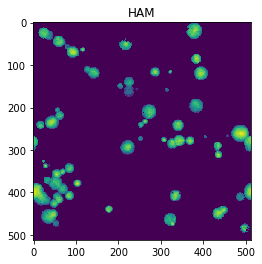

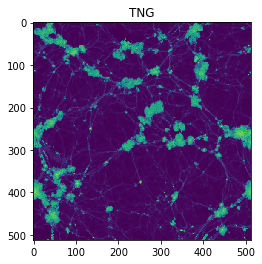

In [9]:
#produces the emulated version of the reference simulation and displays them.  Note that there are large discrepancies
#between the model and reference simulation owning to the highly simplified framework applied here.  This is a compromise between speed (as compared
# to full MHD simulations) and understanding (as in painting in magnetic field with machine learning)
#the model would not converge to the true refernce magnetic field even if mass threshold was set to zero

B_polluted=emulateBubbles(pos,M,dens,Bavg,indexes,dims=64,rescale_factor=1,Mthresh=Mass_threshold)
#A,Masses and Envirs are loaded from file unless specified.  Rescale factor is 1 as we are feeding the 
#sim back into itself

box_size=100
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(B_polluted[:,:,256,:]**2,axis=2)))))
plt.title('HAM')
plt.show()
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(BOG[:,:,256,:]**2,axis=2)))))
plt.title('TNG')
plt.show()

z=0
z=0.0
z=0.0
z=0.1
z=0.1
z=0.1
z=0.1
z=0.2
z=0.2
z=0.2
z=0.2
z=0.2
z=0.3
z=0.3
z=0.3
z=0.3
z=0.3
z=0.4
z=0.4
z=0.4
z=0.4
z=0.4
z=0.5
z=0.5
z=0.5
z=0.5
z=0.5
z=0.6
z=0.6
z=0.6
z=0.6
z=0.6
z=0.7
z=0.7
z=0.7
z=0.7
z=0.7
z=0.8
z=0.8
z=0.8
z=0.8
z=0.8
z=0.9
z=0.9
z=0.9
z=0.9
z=0.9
z=1.0
z=1.0
z=0
z=0.0
z=0.0
z=0.1
z=0.1
z=0.1
z=0.1
z=0.2
z=0.2
z=0.2
z=0.2
z=0.2
z=0.3
z=0.3
z=0.3
z=0.3
z=0.3
z=0.4
z=0.4
z=0.4
z=0.4
z=0.4
z=0.5
z=0.5
z=0.5
z=0.5
z=0.5
z=0.6
z=0.6
z=0.6
z=0.6
z=0.6
z=0.7
z=0.7
z=0.7
z=0.7
z=0.7
z=0.8
z=0.8
z=0.8
z=0.8
z=0.8
z=0.9
z=0.9
z=0.9
z=0.9
z=0.9
z=1.0
z=1.0
8.827610041331651


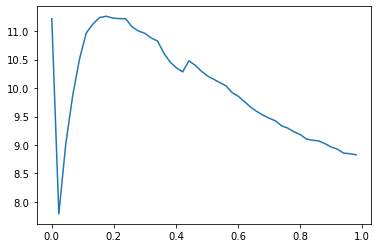

In [10]:
#Renormalises the galactic pollution field.  The strength of rotation the rotation measure is typically suppressed by a factor of about 7-8 with
#the current set up.  It is not caused by ther incorrect field coherence length (I have tried it with always setting the field to be in a single direction).
#The underestimate is likely caused by the spherical averaging procedure essentially ignoring small pockets of relatively 
#strong magnetic fields


box_size=100 #in Mpc
znorm=1
#the redshift at which the refence simulation agrees with the HAM model.  If the model was perfect then this parameter 
#would not matter
C=Compute_Norm(B_polluted,dens,box_size,znorm,BOG)
print(C)

interpolating profiles
0 %
45 %
91 %
calculating field...
0%
1%
3%
5%
7%
9%
11%
13%
15%
17%
19%
21%
23%
25%
27%
29%
31%
33%
35%
37%
39%
41%
43%
45%
47%
49%
51%
53%
55%
57%
59%
61%
63%
65%
67%
69%
71%
73%
75%
77%
79%
81%
83%
85%
87%
89%
91%
93%
95%
97%
99%
-------------------
Running p_field_gen
-------------------
This function may be slow to execute depending on the size of the input cube


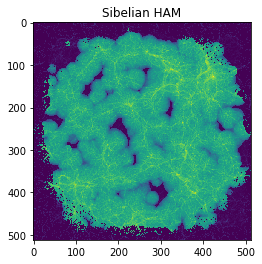

In [11]:
#produces the painted field for the Sibelius simulation, normalised to the factor found for TNG,
#and adding a primordial component.  You could probably ignore the primordial part for a field as weak
#as it is in TNG however



#this is extremely slow, so may want to experiment with higher threshold masses.  

B_sib=emulateBubbles(pos_sib,M_sib,dens_sib,Bavg,indexes,dims=64,rescale_factor=936.8/2/100,Mthresh=Mass_threshold)*C+p_field_gen(dens_sib,amplitude=1e-14,frac=0.1,scale=16)

#B_sib=emulateBubbles(pos_sib,M_sib,dens_sib,Bavg,indexes,dims=64,rescale_factor=936.8/2/100,Mthresh=3e11)*C+p_field_gen(dens_sib,amplitude=1e-14,frac=0.1,scale=16)
#multiply by corrective constant and add primoridal field
plt.imshow(np.log(1e-14+(np.sqrt(np.sum(B_sib[:,:,256,:]**2,axis=2)))))
plt.title('Sibelian HAM')
plt.show()
np.savez("Sibfield",B_sib)



No opencl support


allocating map
initializing views
progress?


|################################################################|Time: 0:00:36
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


19 Clusters found


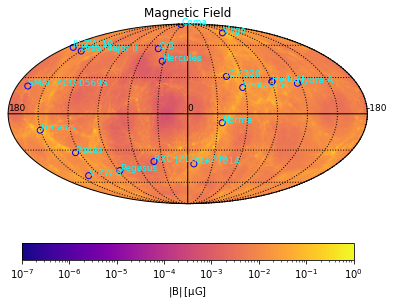

In [12]:
#for further visualisation
#requires use of cosmotool

#next few cells are for visualisation of the data, but were not used in the paper


import cosmotool




nside=256
dist=100

Bhp=cosmotool.spherical_projection(nside,np.transpose(np.sqrt(np.sum(B_sib**2,axis=3)),(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)/dist


MW_plt(abs(Bhp/1e-6),-8,True,"Magnetic Field",-7,0,"plasma","B",None,r'$\rm |B|\:[\mu G]$')

MW_name_plt("B","HAM")

#BhpOG=cosmotool.spherical_projection(nside,np.transpose(np.sqrt(np.sum(BOG**2,axis=3)),(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)/dist




In [13]:


dirs=radial(512)
RMsss=dens_sib.reshape((512,512,512))*(dirs[:,:,:,0]*B_sib[:,:,:,0].reshape((512,512,512))+dirs[:,:,:,1]*B_sib[:,:,:,1].reshape((512,512,512))+dirs[:,:,:,2]*B_sib[:,:,:,2].reshape((512,512,512)))


RMhp=cosmotool.spherical_projection(nside,np.transpose(RMsss,(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)


allocating map
initializing views
progress?


|################################################################|Time: 0:00:36


19 Clusters found


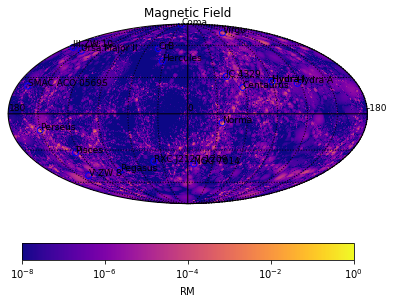

In [14]:
MW_plt(abs(RMhp),-8,True,"Magnetic Field",-8,0,"plasma","g",None,r'$\rm RM$')

MW_name_plt("RM","HAM")

In [15]:
#from this point onward reproduces plots from paper

-------------------
Running p_field_gen
-------------------
This function may be slow to execute depending on the size of the input cube


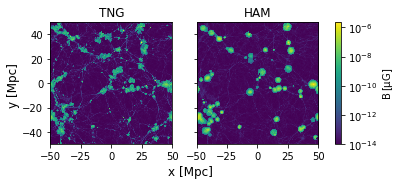

In [16]:
#fig 1, comparing TNG and model


fig_size = (6, 5.5)
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=fig_size)

#generate final TNG-like field
HAME=C*B_polluted+p_field_gen(dens,amplitude=1e-14,frac=0.1,scale=16)
HAM=np.sqrt(np.sum((HAME)**2,axis=3))
Bn=np.sqrt(np.sum((BOG)**2,axis=3))


axes[0].set_title("TNG")
axes[0].imshow(np.log(1e-14+Bn[:,:,256]),extent=(-50,50,-50,50),rasterized=True)
axes[1].set_title("HAM")
axes[1].imshow(np.log(1e-14+HAM.reshape((512,512,512))[:,:,256]),extent=(-50,50,-50,50),rasterized=True)


cmap='viridis'
cbar_title=r'$\rm B\: [\mu G]$'
cnorm=colors.LogNorm(vmax=np.max(Bn[:,:,256]),vmin=1e-14)
plt.colorbar(plt.cm.ScalarMappable(norm=cnorm,cmap=cmap),aspect=20,shrink=0.41,ax=axes[:],label=cbar_title,orientation='vertical')
axes[1].set_xlabel('.', color=(0, 0, 0, 0))
axes[1].set_ylabel('.', color=(0, 0, 0, 0))
fig.text(0.45, 0.28, 'x [Mpc]', va='center', ha='center', fontsize='large')
fig.text(0.04, 0.5,'y [Mpc]' , va='center', ha='center', rotation='vertical', fontsize='large')

if(not os.path.isfile('TNG_plts')):
   os.system('mkdir TNG_plots')
plt.savefig("TNG_plots/B.pdf")
plt.show()

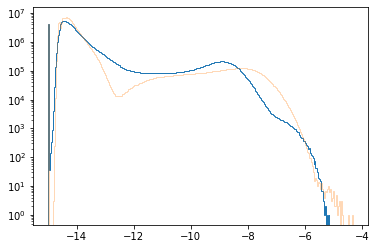

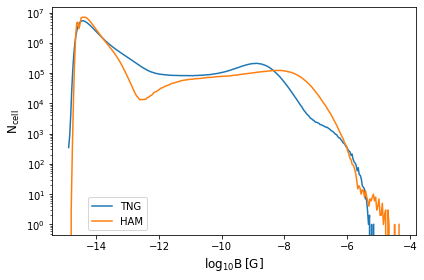

In [17]:
#fig 2 histograms of magnetic field

plt.yscale('log')
s1=plt.hist(np.log10(Bn.ravel()+1e-15),alpha=1,bins=300,histtype='step')#s=plt.hist(np.log10(HAM+1e-15),alpha=0.3,bins=300)
s2=plt.hist(np.log10(HAM.ravel()+1e-15),alpha=0.3,bins=300,histtype='step')
plt.show()
plt.yscale('log')
plt.plot(0.5*(s1[1][3:-1]+s1[1][4:]),s1[0][3:])
plt.plot(0.5*(s2[1][3:-1]+s2[1][4:]),s2[0][3:])
plt.legend(['TNG','HAM'],loc=(0.1,0.02))#(1.02,0.22))
xlab=plt.xlabel(r'$\rm log_{10} B\:[ G]$', fontsize=12)
ylab=plt.ylabel(r'$\rm N_{cell}$', fontsize=12)
plt.tight_layout()
plt.savefig("TNG_plots/B_hist_red.pdf",bbox_extra_artists=(xlab,ylab), bbox_inches='tight')


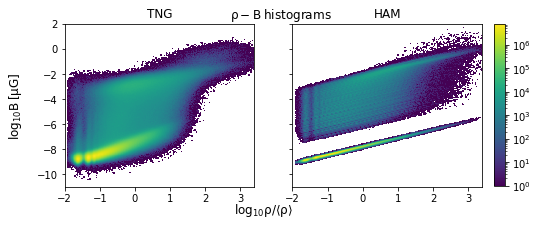

In [18]:
densmi=-2
densma=3.4
Bimi=-11
Bima=2
#fig 3, 2-d histogram density vs B 



fig_size = (8, 3)
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=fig_size)

axes[0].set_title("TNG")
axes[0].hist2d(np.log10(dens.ravel()/(np.average(dens))+1e-20),np.log10(Bn.ravel()+1e-20)+6,bins=(500,500),range=((densmi,densma),(Bimi,Bima)),norm=colors.LogNorm(),rasterized=True)

axes[1].set_title("HAM")
axes[1].hist2d(np.log10(dens.ravel()/(np.average(dens))+1e-20),np.log10(HAM.ravel()+1e-20)+6,bins=(500,500),range=((densmi,densma),(Bimi,Bima)),norm=colors.LogNorm(),rasterized=True)


cnorm=colors.LogNorm(vmax=7965169.0,vmin=1)
cbar_title=''
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.13, 0.02, 0.75])

plt.colorbar(plt.cm.ScalarMappable(norm=cnorm,cmap=cmap),aspect=30,shrink=1,cax=cbar_ax,label=cbar_title,orientation='vertical')


axes[-1].set_xlabel('.', color=(0, 0, 0, 0))
axes[-1].set_ylabel('.', color=(0, 0, 0, 0))
fig.text(0.47, 0.02, r'$\rm log_{10} \rho/\langle\rho\rangle$', va='center', ha='center', fontsize='large')
fig.text(0.04, 0.5,r'$\rm log_{10} B\:[\mu G]$' , va='center', ha='center', rotation='vertical', fontsize='large')
fig.text(0.5, 0.92, r"$\rm \rho-B \: histograms$", va='center', ha='center', fontsize='large')


plt.savefig("TNG_plots/rhoB_red.pdf")
plt.show()




z=0
z=0.0
z=0.0
z=0.1
z=0.1
z=0.1
z=0.1
z=0.2
z=0.2
z=0.2
z=0.2
z=0.2
z=0.3
z=0.3
z=0.3
z=0.3
z=0.3
z=0.4
z=0.4
z=0.4
z=0.4
z=0.4
z=0.5
z=0.5
z=0.5
z=0.5
z=0.5
z=0.6
z=0.6
z=0.6
z=0.6
z=0.6
z=0.7
z=0.7
z=0.7
z=0.7
z=0.7
z=0.8
z=0.8
z=0.8
z=0.8
z=0.8
z=0.9
z=0.9
z=0.9
z=0.9
z=0.9
z=1.0
z=1.0
z=1.0
z=1.0
z=1.0
z=1.1
z=1.1
z=1.1
z=1.1
z=1.1
z=1.2
z=1.2
z=1.2
z=1.2
z=1.2
z=1.3
z=1.3
z=1.3
z=1.3
z=1.4
z=1.4
z=1.4
z=1.4
z=1.4
z=1.5
z=1.5
z=1.5
z=1.5
z=1.5
z=1.6
z=1.6
z=1.6
z=1.6
z=1.7
z=1.7
z=1.7
z=1.7
z=1.7
z=1.8
z=1.8
z=1.8
z=1.8
z=1.8
z=1.9
z=1.9
z=1.9
z=1.9
z=2.0
z=2.0
z=2.0
z=2.0
z=2.1
z=2.1
z=2.1
z=2.1
z=2.1
z=2.2
z=2.2
z=2.2
z=2.2
z=2.3
z=2.3
z=2.3
z=2.3
z=2.4
z=2.4
z=2.4
z=2.4
z=2.5
z=2.5
z=2.5
z=2.5
z=2.5
z=2.6
z=2.6
z=2.6
z=2.6
z=2.7
z=2.7
z=2.7
z=2.7
z=2.8
z=2.8
z=2.8
z=2.8
z=2.9
z=2.9
z=2.9
z=2.9
z=3.0
z=3.0
z=0
z=0.0
z=0.0
z=0.1
z=0.1
z=0.1
z=0.1
z=0.2
z=0.2
z=0.2
z=0.2
z=0.2
z=0.3
z=0.3
z=0.3
z=0.3
z=0.3
z=0.4
z=0.4
z=0.4
z=0.4
z=0.4
z=0.5
z=0.5
z=0.5
z=0.5
z=0.5
z=0.6
z=0.6
z=

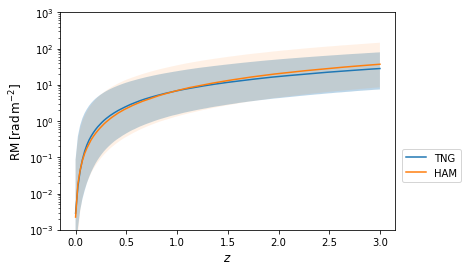

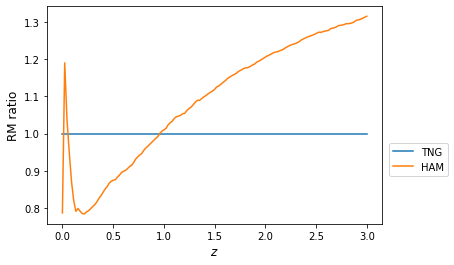

In [19]:
#fig 4, line of sight accumulated RM
def RMtemp(Blist,dens,RM_const):
    s=dens.shape
    RM=np.zeros((s[0],s[1],s[2],3),dtype=float)

    
    RM[:,:,:,0]=dens*Blist[0].reshape(s)*RM_const
    RM[:,:,:,1]=dens*Blist[1].reshape(s)*RM_const
    RM[:,:,:,2]=dens*Blist[2].reshape(s)*RM_const
    return [RM]



chi=5./7
n_const=2.84615e-30/1.67e-24*chi
RM_const=(4.803e-10)**3/(2*np.pi*9.11e-28**2*3e10**4)*1e4*n_const
dist_units=100*3.08e24/512 #cms/cell





interm=RMtemp([BOG[:,:,:,0].ravel(),BOG[:,:,:,1].ravel(),BOG[:,:,:,2].ravel()],dens,(RM_const*dist_units))
psTNG,zo=lin_int(interm,[0],3,100)


interm=RMtemp([HAME[:,:,:,i] for i in range(3)],dens,(RM_const*dist_units))
psHAM,zo=lin_int(interm,[0],3,100)





plt.plot(zo,psTNG[0])
plt.fill_between(zo,psTNG[1],psTNG[2],alpha=0.3)




plt.plot(zo,psHAM[0])
plt.fill_between(zo,psHAM[1],psHAM[2],alpha=0.1)


ledge=plt.legend(['TNG','HAM'],loc=(1.02,0.22))
ylab=plt.ylabel(r'$\rmRM\:[rad\,m^{-2}]$', fontsize=12)
xlab=plt.xlabel(r'$z$', fontsize=12)


plt.yscale('log')

plt.savefig("TNG_plots/RM_z_red.pdf",bbox_extra_artists=(xlab,ylab,ledge), bbox_inches='tight')
plt.ylim([1e-3,1e3])
plt.yscale('log')
plt.show()

plt.plot(zo,psTNG[0]/psTNG[0])
plt.plot(zo,psHAM[0]/psTNG[0])


ledge=plt.legend(['TNG','HAM'],loc=(1.02,0.22))
#plt.ylim()
plt.ylabel('RM ratio', fontsize=12)
#plt.yscale('log')
plt.xlabel(r'$z$', fontsize=12)

plt.savefig("TNG_plots/RM_ratio_red.pdf",bbox_extra_artists=(xlab,ylab,ledge), bbox_inches='tight')

plt.show()


allocating map
initializing views
progress?


|################################################################|Time: 0:00:35


0
1
2
3
4
5
6
7
19 Clusters found


/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


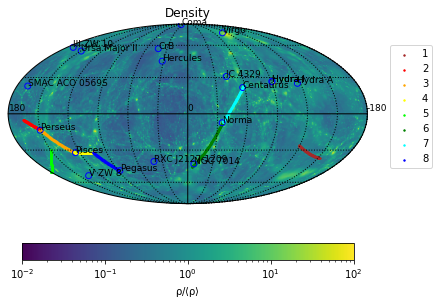

In [21]:
#fig 5 left, density field with accompanying filaments
dhp=cosmotool.spherical_projection(nside,np.transpose(dens_sib/np.mean(dens_sib),(2,1,0)), min_distance=3, max_distance=dist, progress=1,integrator_id=1)/dist

colours=['brown','red','orange','yellow','lime','green','cyan','blue','purple','indigo','violet','gold','silver','pink','black']
ra_fils=np.array([[-119,-152],[150,165],[150,126],[126,105],[150,180],[-5,-35],[-35,-60],[105,88]])
dec_fils=np.array([[-26,-37],[-13,-5],[-13,-32],[-32,-32],[-30,-50],[-45,-7],[-7,24],[-32,-48]])

fils=fil_cat(ra_fils,dec_fils)


lister=[]

#hp.mollview(np.log10(dhp),coord="CG",rot=(150,-30))
MW_plt2(dhp,-2,True,"Density",-2,2,"viridis","d",None,r'$\rm \rho/\langle\rho\rangle$')
for i,fil in enumerate(fils):
    print(i)
    col=colours[i]
    #if(not np.any(col==np.array(['black','blue','red','purple','cyan','violet','grey']))):
    lister.append(str(i+1))
    #else:
    #    continue
    fil=fil.spherical
    hp.projscatter(fil.lon,fil.lat,lonlat=True,color=col,coord="CG",s=2)
    
Ledge=plt.legend(lister,loc=(1.06,0.2))
MW_name_plt("d","TNG")
hp.graticule()

plt.savefig('TNG_plots/dhp_fils2.pdf',bbox_extra_artists=(Ledge,Ledge), bbox_inches='tight')
plt.show()


allocating map
initializing views
progress?


|################################################################|Time: 0:01:09
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


19 Clusters found


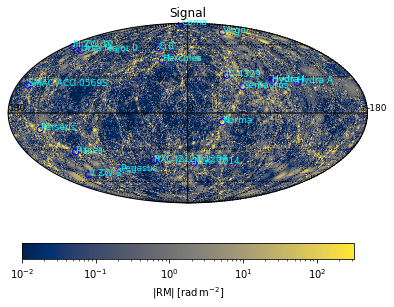

In [25]:
#fig 5 right, RM field, without any foregrounds or backgrounds
dirs=radial(512)
chi=5./7
n_const=2.84615e-30/1.67e-24*chi
nside=256
dist=256*0.75
dist_units=936.8/2*3.08e24/512 #cms/cell
RM_const=(4.803e-10)**3/(2*np.pi*9.11e-28**2*3e10**4)*1e4*n_const
RMsss=dist_units*RM_const*dens_sib*(dirs[:,:,:,0]*B_sib[:,:,:,0]+dirs[:,:,:,1]*B_sib[:,:,:,1]+dirs[:,:,:,2]*B_sib[:,:,:,2])


RMhp=cosmotool.spherical_projection(nside,np.transpose(RMsss,(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)

MW_plt(abs(RMhp),0,True,"Signal",-2.,2.5,'cividis',"B",None,r'$\rm |RM|\:[rad\,m^{-2}]$')



MW_name_plt("B","TNG")
plt.savefig("TNG_plots/RMhp.pdf")

0
1
2
3
4
5
6
7


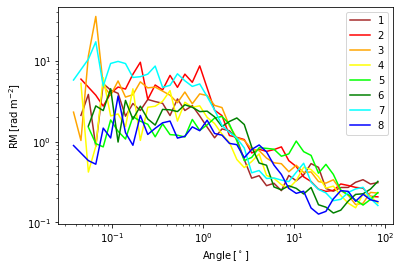

In [26]:
#fig 6, RM versus radius for each of the filaments

fil_hp,fil_all=get_seps(fils,nside,Np=100)


for i,fh in enumerate(fil_hp):
    col=colours[i]
    s=plt_med2d(np.log10(fh),np.log10(abs(RMhp)),bins=50,ranges=(-2,2),color=col)
plt.legend([str(i+1) for i in range(len(fil_hp))],loc='upper right')
plt.ylabel(r'$\rm RM\:[rad\:m^{-2}]$')
plt.xlabel(r'$\rm Angle\:[^\circ]$')
plt.yscale('log')
plt.xscale('log')

plt.savefig("filprofs.pdf")
plt.show()

                

/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


0.7275440677286285
19 Clusters found


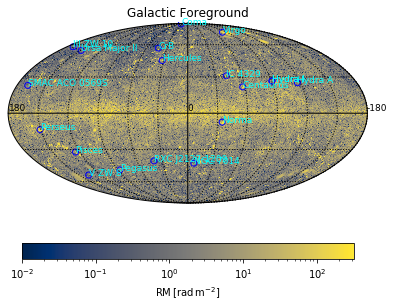

138 75
0.0 0.15525431173859247
0.022689625354989137 0.15643941411237106
0.045116256823265505 0.1685387534218734
0.06730196467577276 0.20224023129860128
0.0892667384480144 0.2590537983955768
0.11102877213358357 0.3314120484660219
0.1326046385116305 0.41623584074692616
0.154009527539706 0.5092203818714309
0.17525737527793533 0.608495329230923
0.196360997031811 0.7115724644101156
0.21733222976660008 0.8195939183154644
0.2381820142392599 0.9282705685436234
0.2589204802231556 1.0368519988296878
0.27955706736369235 1.14766038502664
0.30010053047163615 1.2568949355811432
0.3205590324032819 1.3678215375372522
0.34094022499745275 1.477039529644884
0.36125122507352714 1.5900638968598892
0.38149872870436385 1.6985611245953036
0.40168901828218595 1.8051031601593595
0.4218279889926642 1.908306129471413
0.44192118723632323 2.01384350880614
0.4619738307396762 2.1224269130600257
0.48199086284317033 2.2220843586368426
0.5019769266782831 2.323437969614748
0.5219364349829122 2.41927244520505
0.5418735423

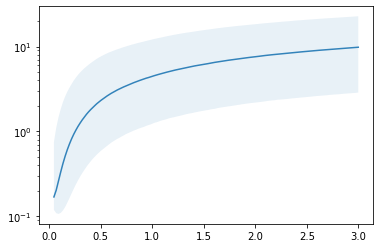

/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


19 Clusters found


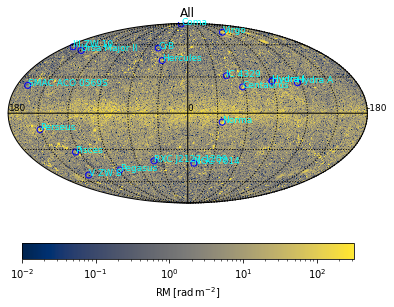

In [27]:
#fig 7 producing the foreground and background.  Foreground is computed from standard deviation in signal
#and is a realisation assuming that the noise of is normal around zero.  Backround assumes that a 
#sightline at a certain redshift has accrued a value from the distribution in fig. 4.  An illuminating source
#is then chosen using a redshift distribution defined by TNG.  Only masses above 10^12 M_sol are allowed to
#act as sources
zi=0.25
zu=np.where(abs(zi-zo)==np.min(abs(zi-zo)))[0][0]
nsides=[2**n for n in range(8,3,-1)]

#for i,zi in enumerate(zo):

sigma=0.5*abs((np.log10(psHAM[1][zu])-np.log10(psHAM[2][zu])))
N_bg=(10**np.random.normal(np.log10(psHAM[0][zu]),sigma,size=RMhp.size))*(np.random.choice([1,-1],size=RMhp.size))

N_inst=RMhp.copy()*0+np.random.normal(0,0.1)
N_fg=hp_interp(fg_load(directory+"faraday2020.hdf5",1),512,nside,'galactic','icrs')

MW_plt(abs(RMhp.copy()+N_bg.copy()*0+N_fg.copy()+N_inst.copy()*0),0,True,"Galactic Foreground",-2.,2.5,'cividis',"B",None,r'$\rm RM\:[rad\,m^{-2}]$')
print(np.median(abs(N_bg)))


MW_name_plt("B","TNG")
plt.savefig("TNG_plots/RMhp_fg.pdf")
plt.show()

#estimating bg sources
N_bgs=[(10**np.random.normal(np.log10(psHAM[0][zu]),0.5*abs((np.log10(psHAM[1][zu])-np.log10(psHAM[2][zu]))),size=RMhp.size))*(np.random.choice([1,-1],size=RMhp.size)) for zu in range(len(zo))]
#randomised contribution of sources according to redshift
Ns=np.array([4371211,4378491,4390068,4398252,4409458,4418121,4429135,4438811,4449889,4459038,4471046,4483167,4491645,4504988,4513460,4527127,4540392,4548171,4563066,4576552,4586259,4605119,4614966,4628753,4644917,4654202,4669362,4685322,4700729,4716081,4731664,4748533,4765222,4782102,4798751,4820852,4838216,4855625,4874876,4897415,4915995,4939851,4958935,4982144,5001549,
    5027739,5052787,5077849,5097548,5127294,5152620,5178463,5202711,5227148,5258883,5284918,5316827,5346842,5377672,5419227,5435697,
    5470709,5496455,5527780,5559130,5588368,5621338,5652823,5682605,
    5708105,5737223,5766174,5792900,5816056,5828784])
#number of sources per 100Mpc^3
zs=np.array([0,0.01,0.02,0.03,0.05,0.06,0.07,0.08,0.1,0.11,0.13,0.14,0.15,0.17,0.18,0.2,0.21,0.23,0.24,0.26,0.27,0.3,0.31,0.33,0.35,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.55,0.58,0.6,0.62,0.64,0.68,0.7,0.73,0.76,0.79,0.82,0.85,0.89,0.92,0.95,1,1.04,1.07,1.11,1.15,1.21,1.25,1.3,1.36,1.41,1.5,1.53,1.6,1.67,1.74,1.82,1.9,2,2.1,2.21,2.32,2.44,2.58,2.73,2.9,3.01])
Ns = interp1d(zs, Ns, kind='cubic',fill_value=(Ns[0],Ns[-1]),bounds_error=False)
Ns=Ns(zo)
harple=[]

print(len(Ns),len(zs))
Vs=cosmo.comoving_distance(zo+0.001).value**3*4*np.pi/3/100**3
Vs[1:]-=Vs[0:-1]

##n_ind=2 for inverse square law, but results may be insensitive to this
#may need steeper law since galaxies are smaller at earlier times, ish
n_ind=0
Ts=Vs*Ns/(1+zo)**n_ind


#estimate background/ instrument contribution

#Tnorm decides the number of objects to include.
#Currently want 20000 sources with z<=1
mval=np.zeros(138,dtype=float)
hval=np.zeros(138,dtype=float)
lval=np.zeros(138,dtype=float)
N_sources=41632
z_sources_norm=1
x=np.where(zo<=z_sources_norm)[0]
Tnorm=np.sum(Ts[x])/N_sources
N_insts=[N_inst/np.sqrt(max([1,T/(12*nside**2)/Tnorm])) for T in Ts]


i=-1

for zi in zo:
    i+=1

    x=np.where(zo<=zi)[0]
    #normalised instrumental noise
    N_tbg=np.sum(np.array(N_insts)[x,:]*np.expand_dims(Ts[x],axis=1),axis=0)/np.sum(Ts[x])

    #weighted sum of distant backgrounds
    N_tbg+=np.sum(np.array(N_bgs)[x,:]*np.expand_dims(Ts[x],axis=1),axis=0)/np.sum(Ts[x])
    mval[i]=np.median(abs(N_tbg))
    hval[i]=np.quantile(abs(N_tbg),0.16)
    lval[i]=np.quantile(abs(N_tbg),0.84)

    print('z={:.2f}, accumulated rotation measure: {:.2f}'.format(zi,mval[i]))

plt.plot(zo[2:],mval[2:],alpha=0.9)
plt.fill_between(zo[2:],hval[2:],lval[2:],alpha=0.1)
plt.yscale('log')
tbg=mval.copy()
plt.show()
true_bg=10**(np.random.normal(np.log10(mval[zu]),0.5*abs((np.log10(lval[zu])-np.log10(hval[zu]))),size=RMhp.size))*np.random.choice([1,-1],size=RMhp.size)

MW_plt(abs(RMhp.copy()+true_bg.copy()+N_fg.copy()),0,True,"All",-2.,2.5,'cividis',"B",None,r'$\rm RM\:[rad\,m^{-2}]$')



MW_name_plt("B","TNG")
plt.savefig("TNG_plots/RMhp_all.pdf")
plt.show()


/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/ramsoy/.local/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


19 Clusters found


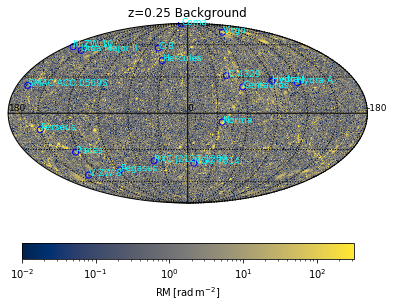

In [28]:
#fig 7 right
MW_plt(abs(RMhp.copy()+true_bg.copy()+0*N_fg.copy()),0,True,"z=0.25 Background",-2.,2.5,'cividis',"B",None,r'$\rm RM\:[rad\,m^{-2}]$')



MW_name_plt("B","TNG")
plt.savefig("TNG_plots/RMhp_bg.pdf")
plt.show()


In [29]:
hm=None

In [31]:

#fig 8. calculate the width of the filaments.  Assumes an inherent noise of 0.1 radm^-2 from instrument, without which 
#the filament doesn't seem to have an edge



U=banned_band(0)
############################
if(hm==None):
    halo_map=cosmotool.spherical_projection(nside,np.transpose(((dens_sib/np.mean(dens_sib))>200)*1.0,(2,1,0)), min_distance=0, max_distance=dist, progress=1,integrator_id=1)/dist
    hm=True
U=np.where(halo_map==0)[0]

N_fil=len(fil_hp)
sizes=np.linspace(0.05,10,200)


ld1darr_fil_q=np.zeros((sizes.size,N_fil),dtype=float)
ld1darr_fil_q_N=np.zeros((sizes.size,N_fil),dtype=float)
count=0
Ntot=ld1darr_fil_q.size
for m,cl in enumerate(fil_hp):
    for i,f in enumerate(sizes):
                        if(count%100==0):
                            print(100*count//Ntot)

            
                        count+=1
                        x=np.where(cl[U]<sizes[i])[0]
                        if(x.size):
                            a=0
                            #ld1darr_fil_q[i,m]=10**np.average(np.log10(trimOutliers(abs(RMhp)[U][x],a)))
                            ld1darr_fil_q[i,m]=np.average(((abs(RMhp)[U][x])))
                            ld1darr_fil_q_N[i,m]=np.std(((abs(RMhp)[U][x])))/np.sqrt(x.size)
                            #ld1darr_fil_q[i,m]=10**np.average(np.log10((abs(RMhp)[U][x])))
                            #ld1darr_fil_q_N[i,m]=(10**np.std(np.log10((abs(RMhp)[U][x]))))/np.sqrt(x.size)
                           
                         



allocating map
initializing views
progress?


|################################################################|Time: 0:01:09


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


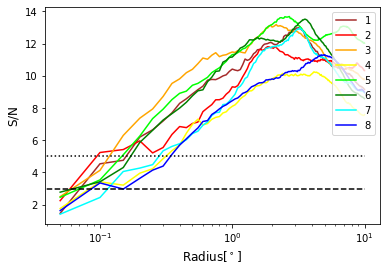

[3.2  2.1  2.15 4.15 2.7  3.55 3.25 4.95]


In [32]:
#plotting fig 8.
colours=['brown','red','orange','yellow','lime','green','cyan','blue','purple','indigo','violet','gold','silver','pink','black']

fil_sizes=np.zeros(8,dtype=float)



for i,fh in enumerate(fil_hp):
        
        col=colours[i]
        
        plt.plot(sizes,(ld1darr_fil_q[:,i]/np.sqrt(0.01+ld1darr_fil_q_N[:,i]**2)),color=col)
        s=(ld1darr_fil_q[:,i]/np.sqrt(0.01+ld1darr_fil_q_N[:,i]**2))
        #print(s,ld1darr_fil_q_N[:,i])
        fil_sizes[i]=sizes[np.where(s==np.max(s))[0][0]]
       
plt.legend([str(i+1) for i in range(len(fil_hp))],loc='upper right')
plt.ylabel(r'$\rm S/N$', fontsize=12)
plt.xlabel(r'$\rm Radius [^\circ]$', fontsize=12)
plt.xscale('log')
plt.plot([0,10],[3,3],color='black',linestyle="--")
plt.plot([0,10],[5,5],color='black',linestyle=":")

plt.savefig("TNG_plots/avg_detectability_quiet_avg.pdf")

plt.show()
print(fil_sizes)

In [33]:
#fig 9. Determining what fraction of current galactic fg we could tolerate while still detecting filaments
sizes=np.linspace(0.1,10,100)
fgal=np.logspace(-3,0,50)
ld1darr_f_fg_N=np.zeros((fgal.size,N_fil),dtype=float)
ld1darr_f_N=np.zeros((fgal.size,N_fil),dtype=float)
ld1darr_f=np.zeros((fgal.size,N_fil),dtype=float)
count=0
Ntot=ld1darr_f_fg_N.size

for m,cl in enumerate(fil_hp):
    size=fil_sizes[m]
    for i,f in enumerate(fgal):
                
                        if(count%100==0):
                            print(100*count//Ntot)

            
                        count+=1
                        x=np.where(cl[U]<size)[0]
                        if(x.size):
                            ld1darr_f_fg_N[i,m]=np.std(((abs(f*N_fg)[U][x])))

                            ld1darr_f[i,m]=np.mean(((abs(RMhp)[U][x])))
                            ld1darr_f_N[i,m]=np.std(((abs(RMhp)[U][x])))/np.sqrt(x.size)
                            

0
4
8
12


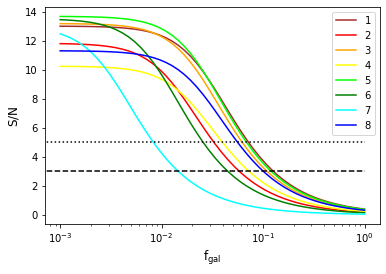

In [34]:
#fig 9


for i,fh in enumerate(fil_hp):
        
        col=colours[i]
        
        plt.plot(fgal,(((ld1darr_f[:,i])/np.sqrt(0.01+ld1darr_f_N[:,i]**2+ld1darr_f_fg_N[:,i]**2))),color=col)
        
        
        
plt.legend([str(i+1) for i in range(len(fil_hp))],loc='upper right')
plt.ylabel(r'$\rm S/N$', fontsize=12)
plt.xlabel(r'$\rm f_{gal}$', fontsize=12)
plt.xscale('log')
#plt.yscale('log')
plt.plot([0,1],[3,3],color='black',linestyle="--")
plt.plot([0,1],[5,5],color='black',linestyle=":")
#plt.xlim((0.6e-2,1))
#plt.ylim((-1.7,10.3))
#plt.savefig("detectability_z"+str(zis[j])+".pdf")
#plt.savefig("detectability_fg.pdf")
plt.savefig("TNG_plots/avg_detectability_fg_avg.pdf")

plt.show()

In [43]:
#fig 10.  Computes the optimal redshift for fig 10, assuming 1000 ish available sources per degree ouyt to z=1
#More distant sources passes through extra structures of unknown density and magnetic field, so despite being
#more numerous can confuse the signal


#find the optimal redshift for a given filament size
#need redshift distribution of number of sources,
#as well as the expected noise at each redshift
#with all sightlines

#fil_sizes=[0.7,1,1,1,1,0.9,1,4]



Ns=np.array([4371211,4378491,4390068,4398252,4409458,4418121,4429135,4438811,4449889,4459038,4471046,4483167,4491645,4504988,4513460,4527127,4540392,4548171,4563066,4576552,4586259,4605119,4614966,4628753,4644917,4654202,4669362,4685322,4700729,4716081,4731664,4748533,4765222,4782102,4798751,4820852,4838216,4855625,4874876,4897415,4915995,4939851,4958935,4982144,5001549,
        5027739,5052787,5077849,5097548,5127294,5152620,5178463,5202711,5227148,5258883,5284918,5316827,5346842,5377672,5419227,5435697,
        5470709,5496455,5527780,5559130,5588368,5621338,5652823,5682605,
        5708105,5737223,5766174,5792900,5816056,5828784])
    #number of sources per 100Mpc^3
zs=np.array([0,0.01,0.02,0.03,0.05,0.06,0.07,0.08,0.1,0.11,0.13,0.14,0.15,0.17,0.18,0.2,0.21,0.23,0.24,0.26,0.27,0.3,0.31,0.33,0.35,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.55,0.58,0.6,0.62,0.64,0.68,0.7,0.73,0.76,0.79,0.82,0.85,0.89,0.92,0.95,1,1.04,1.07,1.11,1.15,1.21,1.25,1.3,1.36,1.41,1.5,1.53,1.6,1.67,1.74,1.82,1.9,2,2.1,2.21,2.32,2.44,2.58,2.73,2.9,3.01])
zs=np.array([0,0.01,0.02,0.03,0.05,0.06,0.07,0.08,0.1,0.11,0.13,0.14,0.15,0.17,0.18,0.2,0.21,0.23,0.24,0.26,0.27,0.3,0.31,0.33,0.35,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.55,0.58,0.6,0.62,0.64,0.68,0.7,0.73,0.76,0.79,0.82,0.85,0.89,0.92,0.95,1,1.04,1.07,1.11,1.15,1.21,1.25,1.3,1.36,1.41,1.5,1.53,1.6,1.67,1.74,1.82,1.9,2,2.1,2.21,2.32,2.44,2.58,2.73,2.9,3.01])
Ns = interp1d(zs, Ns, kind='cubic',fill_value=(Ns[0],Ns[-1]),bounds_error=False)
Ns=Ns(zo)

Vs=cosmo.comoving_distance(zo+0.001).value**3*4*np.pi/3/100**3
Vs[1:]-=Vs[0:-1]







##n_ind=2 for inverse square law, but results may be insensitive to this
#may need steeper law since galaxies are smaller at earlier times, ish

#number of sources per unit redshift




lmedians=np.array(np.log10(psHAM[0]))
lsigmas=np.array([0.5*abs((np.log10(psHAM[1][zu])-np.log10(psHAM[2][zu]))) for zu in range(len(zo))])

zf=np.logspace(-2,np.log10(3),100)
Ns = interp1d(zo, Ns, kind='cubic',fill_value=(Ns[0],Ns[-1]),bounds_error=False)(zf)
Vs=cosmo.comoving_distance(zf+0.001).value**3*4*np.pi/3/100**3
Vs[1:]-=Vs[0:-1]
n_ind=0
Ts=Vs*Ns/(1+zf)**n_ind
lsigmas = interp1d(zo, lsigmas, kind='cubic',fill_value=(lsigmas[0],lsigmas[-1]),bounds_error=False)(zf)
lmedians = interp1d(zo, lmedians, kind='cubic',fill_value=(lmedians[0],lmedians[-1]),bounds_error=False)(zf)
zs=zf
cTs=np.cumsum(Ts)


cTs=cTs#[::3]
zref=0.5
ccc=int(cTs[np.where(abs(zs-zref)==np.min(abs(zs-zref)))[0][0]]/(12*256**2))
print('ccc:',ccc)
ccc=20000
i=np.where(abs(zs-1)==np.min(abs(zs-1)))[0][0]
S=(int(cTs[i])//ccc+4)/41252.96125
print(S, 'sources per square degreee')

Ts=Ts#[::3]

lmedians=lmedians#[::3]
lsigmas=lsigmas#[::3]
ld1darr_fil_z=np.zeros((zs.size,N_fil),dtype=float)
ld1darr_fil_z_N=np.zeros((zs.size,N_fil),dtype=float)

ld1darr_fil_z_bg=np.zeros((zs.size,N_fil),dtype=float)
ld1darr_fil_z_fg=np.zeros((zs.size,N_fil),dtype=float)
count=0
Ntot=ld1darr_fil_z.size
S=0


###
z_ind_func = interp1d(cTs, np.arange(cTs.size), kind='cubic',fill_value=(0,cTs.size-1),bounds_error=False)
#gets the index of the approximate halo number

###


for m,cl in enumerate(fil_hp):
    sss=[]
    zzz=[]
    for i,N in enumerate(zs):
        
                        if(count%2==0):
                            print('{:.2f}%, z={:.2f}, S={:.0f}'.format(100*count/Ntot,zs[i],S))

            
                        count+=1
                        x=np.where(cl[U]<sizes[i])[0]
                        if(x.size):
                            zzz.append(zs[i])
                            sss.append(x.size)
                            #realisation of data:
                            
                           
                            S=int(cTs[i]*x.size/12/256**2)//ccc+4
                            #number of sources in total multiplied by the fraction of 
                            #the sky covered
                          
                            z_indices=np.array(z_ind_func(np.random.randint(cTs[i],size=S)),dtype=int)
                            
                            tmeds=lmedians[(z_indices)]
                            tsigs=lsigmas[(z_indices)]
                            f=0.01
                            temp=np.random.choice((RMhp)[U][x],size=S).ravel()
                            bg_temp=np.array(10**np.random.normal(tmeds,tsigs)).ravel()
                           
                            ld1darr_fil_z[i,m]=np.mean(((abs(temp))))
                            ld1darr_fil_z_N[i,m]=np.std(((abs(temp))))/np.sqrt(S)
                            ld1darr_fil_z_fg[i,m]=np.std(((abs(np.random.choice(N_fg[x]*f,size=S)))))
                            ld1darr_fil_z_bg[i,m]=np.mean(((abs(bg_temp))))
                            


ccc: 186993
990.7044430658902 sources per square degreee
0.00%, z=0.01, S=0
0.00%, z=0.01, S=4
0.00%, z=0.01, S=4
0.00%, z=0.01, S=4
0.00%, z=0.02, S=4
0.00%, z=0.02, S=4
0.00%, z=0.02, S=4
0.00%, z=0.02, S=4
0.00%, z=0.03, S=5
0.00%, z=0.03, S=6
0.00%, z=0.03, S=7
0.00%, z=0.04, S=10
0.00%, z=0.04, S=13
0.01%, z=0.04, S=18
0.01%, z=0.05, S=26
0.01%, z=0.06, S=39
0.01%, z=0.06, S=58
0.01%, z=0.07, S=87
0.01%, z=0.08, S=131
0.01%, z=0.09, S=197
0.01%, z=0.10, S=295
0.01%, z=0.11, S=439
0.01%, z=0.13, S=652
0.01%, z=0.14, S=967
0.01%, z=0.16, S=1430
0.01%, z=0.18, S=2107
0.01%, z=0.20, S=3103
0.01%, z=0.22, S=4546
0.01%, z=0.25, S=6652
0.01%, z=0.28, S=9710
0.01%, z=0.32, S=14118
0.01%, z=0.36, S=20444
0.01%, z=0.40, S=29438
0.01%, z=0.45, S=42230
0.01%, z=0.50, S=60105
0.01%, z=0.56, S=84868
0.01%, z=0.63, S=118910
0.01%, z=0.71, S=165560
0.02%, z=0.80, S=228608
0.02%, z=0.89, S=312975
0.02%, z=1.00, S=424694
0.02%, z=1.13, S=570851
0.02%, z=1.26, S=759609
0.02%, z=1.42, S=999345
0.02%,

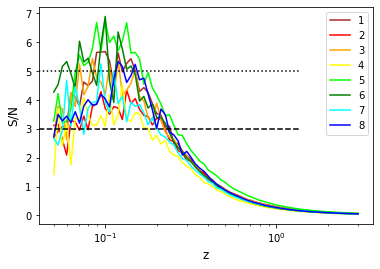

[True, True, True, True, True, True, True, True]

In [44]:
#fig 10
x=np.where(zs>0.05)[0]
for i,fh in enumerate(fil_hp):
        
        col=colours[i]
        
        
        plt.plot(zs[x],(((ld1darr_fil_z[x,i])/np.sqrt(ld1darr_fil_z_N[x,i]**2+ld1darr_fil_z_fg[x,i]**2+ld1darr_fil_z_bg[x,i]**2+0.01))),color=col)
        
        
plt.legend([str(i+1) for i in range(len(fil_hp))],loc='upper right')
plt.ylabel(r'$\rm S/N$', fontsize=12)
plt.xlabel(r'$\rm z$', fontsize=12)
plt.xscale('log')
plt.plot([0,1.36],[3,3],color='black',linestyle="--")
plt.plot([0,1.36],[5,5],color='black',linestyle=":")
#plt.xlim((0.6e-2,1))
#plt.ylim((0.7,10.3))
#plt.savefig("detectability_z"+str(zis[j])+".pdf")
plt.savefig("TNG_plots/avg_detectability_z_avg.pdf")

plt.show()

[sum((((ld1darr_fil_z[:,i])/np.sqrt(ld1darr_fil_z_N[:,i]**2+ld1darr_fil_z_bg[:,i]**2+ld1darr_fil_z_fg[:,i]**2+0.01)))>3)>0 for i in range(8)]

In [45]:
print('finished:',time.time()-start,'s later')

finished: 2987.2184221744537 s later


In [ ]:
#fig 11, repeat but for 100,000 sources per degree, very slow to run
#find the optimal redshift for a given filament size
#need redshift distribution of number of sources,
#as well as the expected noise at each redshift
#with all sightlines

#fil_sizes=[0.7,1,1,1,1,0.9,1,4]



Ns=np.array([4371211,4378491,4390068,4398252,4409458,4418121,4429135,4438811,4449889,4459038,4471046,4483167,4491645,4504988,4513460,4527127,4540392,4548171,4563066,4576552,4586259,4605119,4614966,4628753,4644917,4654202,4669362,4685322,4700729,4716081,4731664,4748533,4765222,4782102,4798751,4820852,4838216,4855625,4874876,4897415,4915995,4939851,4958935,4982144,5001549,
        5027739,5052787,5077849,5097548,5127294,5152620,5178463,5202711,5227148,5258883,5284918,5316827,5346842,5377672,5419227,5435697,
        5470709,5496455,5527780,5559130,5588368,5621338,5652823,5682605,
        5708105,5737223,5766174,5792900,5816056,5828784])
    #number of sources per 100Mpc^3
zs=np.array([0,0.01,0.02,0.03,0.05,0.06,0.07,0.08,0.1,0.11,0.13,0.14,0.15,0.17,0.18,0.2,0.21,0.23,0.24,0.26,0.27,0.3,0.31,0.33,0.35,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.55,0.58,0.6,0.62,0.64,0.68,0.7,0.73,0.76,0.79,0.82,0.85,0.89,0.92,0.95,1,1.04,1.07,1.11,1.15,1.21,1.25,1.3,1.36,1.41,1.5,1.53,1.6,1.67,1.74,1.82,1.9,2,2.1,2.21,2.32,2.44,2.58,2.73,2.9,3.01])
zs=np.array([0,0.01,0.02,0.03,0.05,0.06,0.07,0.08,0.1,0.11,0.13,0.14,0.15,0.17,0.18,0.2,0.21,0.23,0.24,0.26,0.27,0.3,0.31,0.33,0.35,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.5,0.52,0.55,0.58,0.6,0.62,0.64,0.68,0.7,0.73,0.76,0.79,0.82,0.85,0.89,0.92,0.95,1,1.04,1.07,1.11,1.15,1.21,1.25,1.3,1.36,1.41,1.5,1.53,1.6,1.67,1.74,1.82,1.9,2,2.1,2.21,2.32,2.44,2.58,2.73,2.9,3.01])
Ns = interp1d(zs, Ns, kind='cubic',fill_value=(Ns[0],Ns[-1]),bounds_error=False)
Ns=Ns(zo)

Vs=cosmo.comoving_distance(zo+0.001).value**3*4*np.pi/3/100**3
Vs[1:]-=Vs[0:-1]







##n_ind=2 for inverse square law, but results may be insensitive to this
#may need steeper law since galaxies are smaller at earlier times, ish

#number of sources per unit redshift




lmedians=np.array(np.log10(psHAM[0]))
lsigmas=np.array([0.5*abs((np.log10(psHAM[1][zu])-np.log10(psHAM[2][zu]))) for zu in range(len(zo))])

zf=np.logspace(-2,np.log10(3),100)
Ns = interp1d(zo, Ns, kind='cubic',fill_value=(Ns[0],Ns[-1]),bounds_error=False)(zf)
Vs=cosmo.comoving_distance(zf+0.001).value**3*4*np.pi/3/100**3
Vs[1:]-=Vs[0:-1]
n_ind=0
Ts=Vs*Ns/(1+zf)**n_ind
lsigmas = interp1d(zo, lsigmas, kind='cubic',fill_value=(lsigmas[0],lsigmas[-1]),bounds_error=False)(zf)
lmedians = interp1d(zo, lmedians, kind='cubic',fill_value=(lmedians[0],lmedians[-1]),bounds_error=False)(zf)
zs=zf
cTs=np.cumsum(Ts)


cTs=cTs#[::3]
zref=0.5
ccc=int(cTs[np.where(abs(zs-zref)==np.min(abs(zs-zref)))[0][0]]/(12*256**2))
print('ccc:',ccc)
ccc=200
i=np.where(abs(zs-1)==np.min(abs(zs-1)))[0][0]
S=(int(cTs[i])//ccc+4)/41252.96125
print(S, 'sources per square degreee')

Ts=Ts#[::3]

lmedians=lmedians#[::3]
lsigmas=lsigmas#[::3]
ld1darr_fil_z2=np.zeros((zs.size,N_fil),dtype=float)
ld1darr_fil_z_N2=np.zeros((zs.size,N_fil),dtype=float)

ld1darr_fil_z_bg2=np.zeros((zs.size,N_fil),dtype=float)
ld1darr_fil_z_fg2=np.zeros((zs.size,N_fil),dtype=float)
count=0
Ntot=ld1darr_fil_z2.size
S=0


###
z_ind_func = interp1d(cTs, np.arange(cTs.size), kind='cubic',fill_value=(0,cTs.size-1),bounds_error=False)
#gets the index of the approximate halo number

###


for m,cl in enumerate(fil_hp):
    sss=[]
    zzz=[]
    for i,N in enumerate(zs):
        
                        if(count%2==0):
                             print('{:.2f}%, z={:.2f}, S={:.0f}'.format(100*count/Ntot,zs[i],S))
            
                        count+=1
                        x=np.where(cl[U]<sizes[i])[0]
                        if(x.size):
                            zzz.append(zs[i])
                            sss.append(x.size)
                            #realisation of data:
                            
                           
                            S=int(cTs[i]*x.size/12/256**2)//ccc+4
                            #number of sources in total multiplied by the fraction of 
                            #the sky covered
                          
                            z_indices=np.array(z_ind_func(np.random.randint(cTs[i],size=S)),dtype=int)
                            
                            #z_indices=[np.where(abs(zch_r-cTs[:i+1])==np.min(abs(zch_r-cTs[:i+1])))[0][0] for zch_r in zch_rs]
                            ######################
                            tmeds=lmedians[(z_indices)]
                            tsigs=lsigmas[(z_indices)]
                            f=0.01
                            temp=np.random.choice((RMhp)[U][x],size=S).ravel()
                            bg_temp=np.array(10**np.random.normal(tmeds,tsigs)).ravel()
                            
                            ld1darr_fil_z2[i,m]=np.mean(((abs(temp))))
                            ld1darr_fil_z_N2[i,m]=np.std(((abs(temp))))/np.sqrt(S)
                            ld1darr_fil_z_fg2[i,m]=np.std(((abs(np.random.choice(N_fg[x]*f,size=S)))))
                            
                            ld1darr_fil_z_bg2[i,m]=np.mean(((abs(bg_temp))))
                            


ccc: 186993
99070.43664653286 sources per square degreee
0.00%, z=0.01, S=0
0.00%, z=0.01, S=5
0.00%, z=0.01, S=8
0.00%, z=0.01, S=13
0.00%, z=0.02, S=21
0.00%, z=0.02, S=34
0.00%, z=0.02, S=56
0.00%, z=0.02, S=94
0.00%, z=0.03, S=155
0.00%, z=0.03, S=250
0.00%, z=0.03, S=396
0.00%, z=0.04, S=616
0.00%, z=0.04, S=951
0.01%, z=0.04, S=1469
0.01%, z=0.05, S=2261
0.01%, z=0.06, S=3516
0.01%, z=0.06, S=5451
0.01%, z=0.07, S=8403
0.01%, z=0.08, S=12784
0.01%, z=0.09, S=19347
0.01%, z=0.10, S=29130
0.01%, z=0.11, S=43563
0.01%, z=0.13, S=64897
0.01%, z=0.14, S=96368
0.01%, z=0.16, S=142616
0.01%, z=0.18, S=210339
0.01%, z=0.20, S=309931
0.01%, z=0.22, S=454259
0.01%, z=0.25, S=664846
0.01%, z=0.28, S=970622
0.01%, z=0.32, S=1411484
0.01%, z=0.36, S=2044084
0.01%, z=0.40, S=2943427
0.01%, z=0.45, S=4222671
0.01%, z=0.50, S=6010168
0.01%, z=0.56, S=8486463
0.01%, z=0.63, S=11890638
0.01%, z=0.71, S=16555688
0.02%, z=0.80, S=22860475
0.02%, z=0.89, S=31297110
0.02%, z=1.00, S=42469056
0.02%, z=

In [ ]:

x=np.where(zs>0.05)[0]
for i,fh in enumerate(fil_hp):
        
        col=colours[i]
        
        
        
        plt.plot(zs[x],(((ld1darr_fil_z2[x,i])/np.sqrt(ld1darr_fil_z_N2[x,i]**2+ld1darr_fil_z_fg2[x,i]**2+ld1darr_fil_z_bg2[x,i]**2+0.01))),color=col)
        
        
plt.legend([str(i+1) for i in range(len(fil_hp))],loc='upper right')
plt.ylabel(r'$\rm S/N$', fontsize=12)
plt.xlabel(r'$\rm z$', fontsize=12)
plt.xscale('log')
plt.plot([0,1.36],[3,3],color='black',linestyle="--")
plt.plot([0,1.36],[5,5],color='black',linestyle=":")
#plt.xlim((0.6e-2,1))
#plt.ylim((0.7,10.3))
#plt.savefig("detectability_z"+str(zis[j])+".pdf")
plt.savefig("TNG_plots/avg_detectability_z_avg10.pdf")

plt.show()

[sum((((ld1darr_fil_z[:,i])/np.sqrt(ld1darr_fil_z_N2[:,i]**2+ld1darr_fil_z_bg2[:,i]**2+ld1darr_fil_z_fg2[:,i]**2+0.01)))>3)>0 for i in range(8)]

In [ ]:
print('finished:',time.time()-start,'s later')